# Chadplace Fantasy Baseball Analysis

This notebook loads `chadplace.csv`, computes standings/metrics, and plots trajectories, rolling averages, and distributions.

In [1]:

# Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt

csv_path = '/Users/anthonyvaleh/Desktop/chadplace.csv'
df = pd.read_csv(csv_path)
df = df.rename(columns={df.columns[0]:'Date'})
names = [c for c in df.columns if c != 'Date']
for c in names:
    df[c] = pd.to_numeric(df[c], errors='coerce')
df.tail()


,Date,Connor,Anthony,Jake,Ed/Blake,Bob,Ryan,Nathan,Scott,Tom,Holden,Jonathon,Youngkin,Jackson
181,25Sep,-7,-13,-6,-12,-8,-11,-2,-5,-10,-1,-3,-4,-9
182,26Sep,-7,-13,-6,-12,-9,-11,-2,-5,-8,-1,-3,-4,-9
183,27Sep,-7,-13,-5,-12,-10,-11,-2,-6,-9,-1,-3,-4,-8
184,28Sep,-7,-13,-5,-11,-8,-12,-2,-6,-9,-1,-3,-4,-10
185,29Sep,-7,-13,-5,-11,-9,-12,-2,-6,-8,-1,-3,-4,-10


In [2]:

# Helper functions

def longest_streak(series, predicate):
    longest=0; cur=0
    for v in series:
        if predicate(v):
            cur+=1; longest=max(longest,cur)
        else:
            cur=0
    return longest

row_maxs = df[names].max(axis=1)
max_counts = (df[names].eq(row_maxs, axis=0)).sum(axis=1)


In [3]:

# Compute per-person metrics
rows = []
for name in names:
    s=df[name].dropna()
    rows.append(dict(
        Name=name,
        Days=len(s),
        Best=int(s.min()),
        Worst=int(s.max()),
        Avg=float(s.mean()),
        Median=float(s.median()),
        StdDev=float(s.std(ddof=0)),
        DaysFirst=int((s==-1).sum()),
        DaysTop3=int(s.isin([-1,-2,-3]).sum()),
        DaysTop5=int(s.isin([-1,-2,-3,-4,-5]).sum()),
        LeadDays=int((df[name]==row_maxs).sum()),
        SoloLeadDays=int(((df[name]==row_maxs) & (max_counts==1)).sum()),
        LongestFirstStreak=longest_streak(s, lambda v: v==-1),
        LongestTop3Streak=longest_streak(s, lambda v: v in (-1,-2,-3)),
        FirstDayInFirst=str(df.loc[(df[name]==-1), 'Date'].iloc[0]) if (df[name]==-1).any() else '',
        LastDayInFirst=str(df.loc[(df[name]==-1), 'Date'].iloc[-1]) if (df[name]==-1).any() else '',
    ))
res = pd.DataFrame(rows)
stand_avg = res.sort_values(['Avg','StdDev','Name'], ascending=[False, True, True])
stand_avg


,Name,Days,Best,Worst,Avg,Median,StdDev,DaysFirst,DaysTop3,DaysTop5,LeadDays,SoloLeadDays,LongestFirstStreak,LongestTop3Streak,FirstDayInFirst,LastDayInFirst
9,Holden,186,-8,-1,-1.397849,-1.0,1.043565,147,179,182,148,145,68,168,1Apr,29Sep
6,Nathan,186,-8,-1,-2.693548,-2.0,1.221519,20,146,178,20,18,9,89,7May,10Aug
10,Jonathon,186,-10,-1,-3.596774,-3.0,1.870481,4,130,159,4,4,4,68,28Mar,31Mar
11,Youngkin,186,-10,-1,-3.666667,-4.0,1.242901,1,68,176,2,1,1,48,14May,14May
2,Jake,186,-8,-1,-4.822581,-5.0,1.401123,14,22,139,14,13,11,22,2Apr,18Apr
7,Scott,186,-13,-4,-7.241935,-7.0,1.981247,0,0,34,0,0,0,0,,
0,Connor,186,-11,-1,-7.311828,-7.0,1.883594,2,11,24,2,1,1,8,7Apr,13Apr
4,Bob,186,-13,-4,-7.370968,-8.0,1.543985,0,0,28,0,0,0,0,,
8,Tom,186,-11,-3,-8.784946,-9.0,1.746576,0,2,13,0,0,0,2,,
5,Ryan,186,-13,-4,-8.870968,-9.0,1.907686,0,0,1,0,0,0,0,,


In [4]:

# League-wide stats and distributions
overall = df[names].stack()
place_counts = overall.value_counts().sort_index()
print('Dates:', df['Date'].iloc[0], '→', df['Date'].iloc[-1], 'Days:', len(df))
print('Observations:', overall.size)
print('Mean rank:', overall.mean(), 'Median:', overall.median(), 'Std:', overall.std(ddof=0))
place_counts


Dates: 28Mar → 29Sep Days: 186
Observations: 2418
Mean rank: -6.969396195202647 Median: -7.0 Std: 3.7316817722906612


-13    179
-12    190
-11    180
-10    184
-9     186
-8     188
-7     186
-6     186
-5     193
-4     188
-3     184
-2     186
-1     188
Name: count, dtype: int64

In [5]:

# Consistency, Momentum, Volatility
consistency = res.copy()
consistency['Range']=consistency['Worst']-consistency['Best']
consistency['CoeffVar']=consistency['StdDev']/consistency['Avg'].abs()

last7=df.tail(7)
rows2=[]
for name in names:
    delta=float(last7[name].mean()-df[name].mean())
    rows2.append(dict(Name=name, SeasonAvg=float(df[name].mean()), Last7Avg=float(last7[name].mean()), Momentum=delta))
momentum=pd.DataFrame(rows2).sort_values('Momentum', ascending=False)

rows3=[]
for name in names:
    changes=int((df[name].diff()!=0).sum())
    rows3.append(dict(Name=name, ChangeDays=changes, ChangeRate=changes/(len(df[name])-1)))
volatility=pd.DataFrame(rows3).sort_values(['ChangeRate','Name'])

consistency, momentum, volatility


(         Name  Days  Best  Worst        Avg  Median    StdDev  DaysFirst  \
 0      Connor   186   -11     -1  -7.311828    -7.0  1.883594          2   
 1     Anthony   186   -13     -5 -11.817204   -12.0  1.473393          0   
 2        Jake   186    -8     -1  -4.822581    -5.0  1.401123         14   
 3   Ed/Blake    186   -13     -4 -11.887097   -12.0  1.610832          0   
 4         Bob   186   -13     -4  -7.370968    -8.0  1.543985          0   
 5        Ryan   186   -13     -4  -8.870968    -9.0  1.907686          0   
 6      Nathan   186    -8     -1  -2.693548    -2.0  1.221519         20   
 7       Scott   186   -13     -4  -7.241935    -7.0  1.981247          0   
 8         Tom   186   -11     -3  -8.784946    -9.0  1.746576          0   
 9      Holden   186    -8     -1  -1.397849    -1.0  1.043565        147   
 10   Jonathon   186   -10     -1  -3.596774    -3.0  1.870481          4   
 11   Youngkin   186   -10     -1  -3.666667    -4.0  1.242901          1   

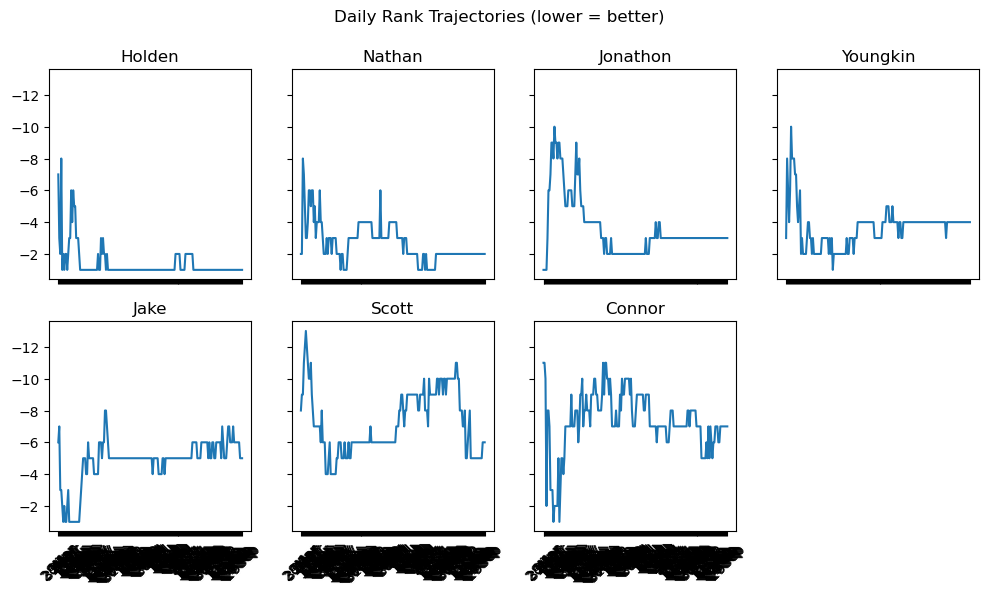

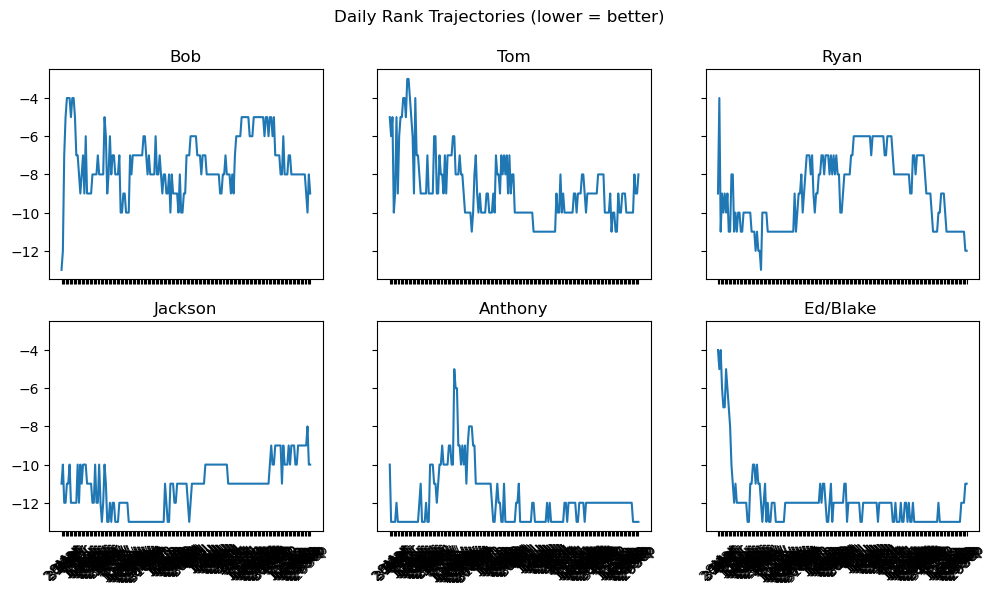

In [6]:

# Plot: trajectories small multiples
import math
people_order=list(stand_avg['Name'])
chunks=[people_order[:7], people_order[7:]]
for chunk in chunks:
    n=len(chunk)
    rows_grid=2
    cols_grid=math.ceil(n/rows_grid)
    fig, axes = plt.subplots(rows_grid, cols_grid, figsize=(12,6), sharex=True, sharey=True)
    axes = np.array(axes).reshape(rows_grid, cols_grid)
    for i,name in enumerate(chunk):
        r=i//cols_grid; c=i%cols_grid
        ax=axes[r,c]
        ax.plot(df['Date'], df[name])
        ax.set_title(name)
        ax.invert_yaxis()
        ax.tick_params(axis='x', rotation=45)
    for i in range(n, rows_grid*cols_grid):
        axes[i//cols_grid, i%cols_grid].axis('off')
    fig.suptitle('Daily Rank Trajectories (lower = better)')
    plt.show()


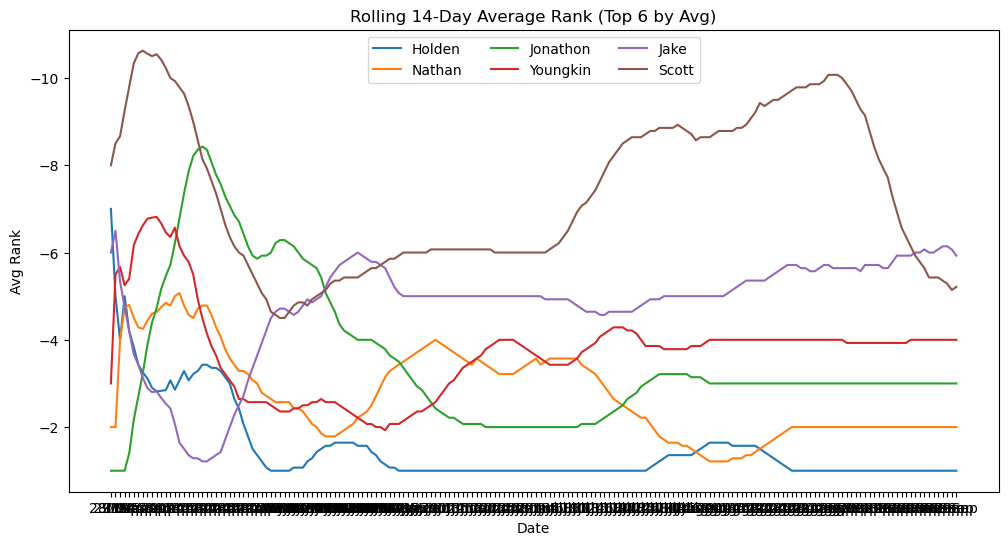

In [7]:

# Plot: rolling 14d averages for top 6 by avg
window=14
fig, ax = plt.subplots(figsize=(12,6))
for name in list(stand_avg['Name'])[:6]:
    ax.plot(df['Date'], df[name].rolling(window, min_periods=1).mean(), label=name)
ax.invert_yaxis(); ax.legend(ncol=3)
ax.set_title(f'Rolling {window}-Day Average Rank (Top 6 by Avg)')
ax.set_xlabel('Date'); ax.set_ylabel('Avg Rank')
plt.show()


## Advanced analyses

In [8]:

import seaborn as sns
import pandas as pd
import numpy as np

# Parse date for grouping
try:
    dt = pd.to_datetime(df['Date'], format='%d%b', errors='coerce')
except Exception:
    dt = pd.to_datetime(df['Date'], errors='coerce')
df_dt = df.copy(); df_dt['dt']=dt
weekly = df_dt.groupby(pd.Grouper(key='dt', freq='W-SUN'))[names].mean()
monthly = df_dt.groupby(pd.Grouper(key='dt', freq='MS'))[names].mean()

# Head-to-head lead matrix
arr = df[names].to_numpy()
lead_matrix = pd.DataFrame(0, index=names, columns=names)
for i,a in enumerate(names):
    for j,b in enumerate(names):
        if i==j: continue
        lead_matrix.iloc[i,j] = int((arr[:,i] > arr[:,j]).sum())

# Spearman correlation of rank time series
corr = df[names].corr(method='spearman')

weekly.tail(), monthly.tail(), lead_matrix.iloc[:5,:5], corr.iloc[:5,:5]


(              Connor    Anthony      Jake  Ed/Blake        Bob       Ryan  \
 dt                                                                          
 1900-09-02 -7.285714 -12.000000 -5.428571 -13.000000 -5.285714  -8.285714   
 1900-09-09 -5.142857 -12.000000 -6.000000 -12.857143 -7.142857 -10.571429   
 1900-09-16 -6.000000 -12.000000 -5.857143 -13.000000 -7.714286 -10.000000   
 1900-09-23 -6.714286 -12.000000 -6.142857 -13.000000 -8.000000 -11.000000   
 1900-09-30 -7.000000 -12.833333 -5.500000 -11.833333 -8.666667 -11.333333   
 
             Nathan      Scott        Tom  Holden  Jonathon  Youngkin  \
 dt                                                                     
 1900-09-02    -2.0 -10.285714  -8.428571    -1.0      -3.0 -4.000000   
 1900-09-09    -2.0  -8.000000  -9.714286    -1.0      -3.0 -3.857143   
 1900-09-16    -2.0  -5.857143 -10.142857    -1.0      -3.0 -4.000000   
 1900-09-23    -2.0  -5.000000  -9.571429    -1.0      -3.0 -4.000000   
 1900-09-30   

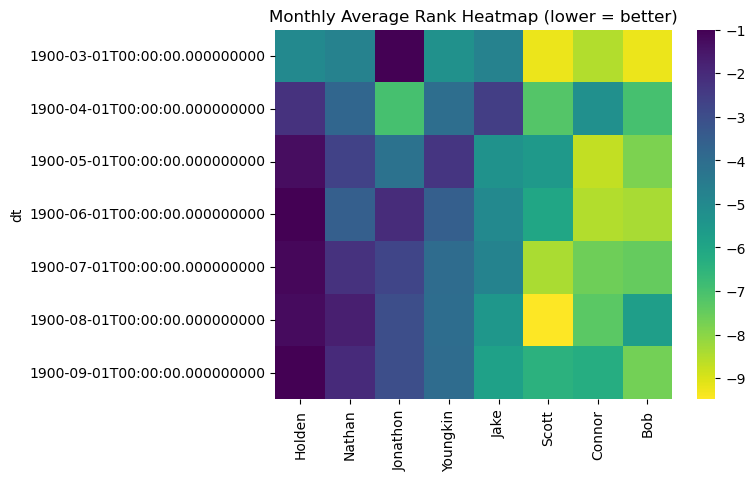

In [9]:

# Heatmap: monthly average ranks for top 8 by average
import seaborn as sns
stand_avg = res.sort_values(['Avg','StdDev','Name'], ascending=[False, True, True])
top_names = list(stand_avg['Name'][:8])
ax = sns.heatmap(monthly[top_names], cmap='viridis_r')
ax.set_title('Monthly Average Rank Heatmap (lower = better)')
plt.show()


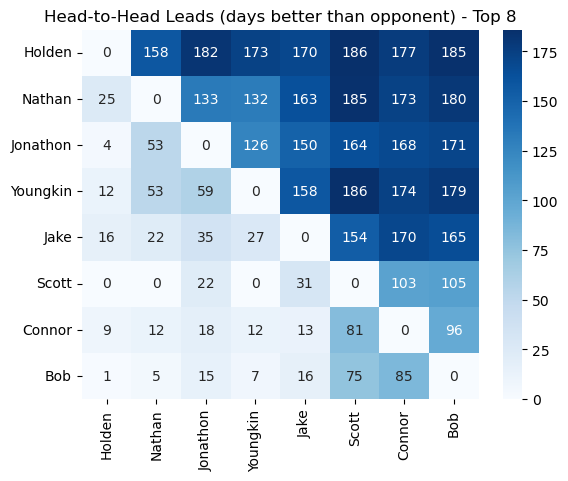

In [10]:

# Heatmap: head-to-head leads (top 8)
ax = sns.heatmap(lead_matrix.loc[top_names, top_names], annot=True, fmt='d', cmap='Blues')
ax.set_title('Head-to-Head Leads (days better than opponent) - Top 8')
plt.show()


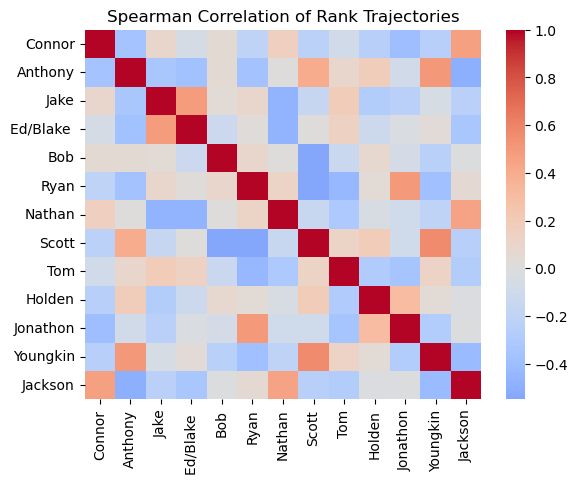

In [11]:

# Heatmap: Spearman correlations (all teams)
ax = sns.heatmap(corr, cmap='coolwarm', center=0)
ax.set_title('Spearman Correlation of Rank Trajectories')
plt.show()


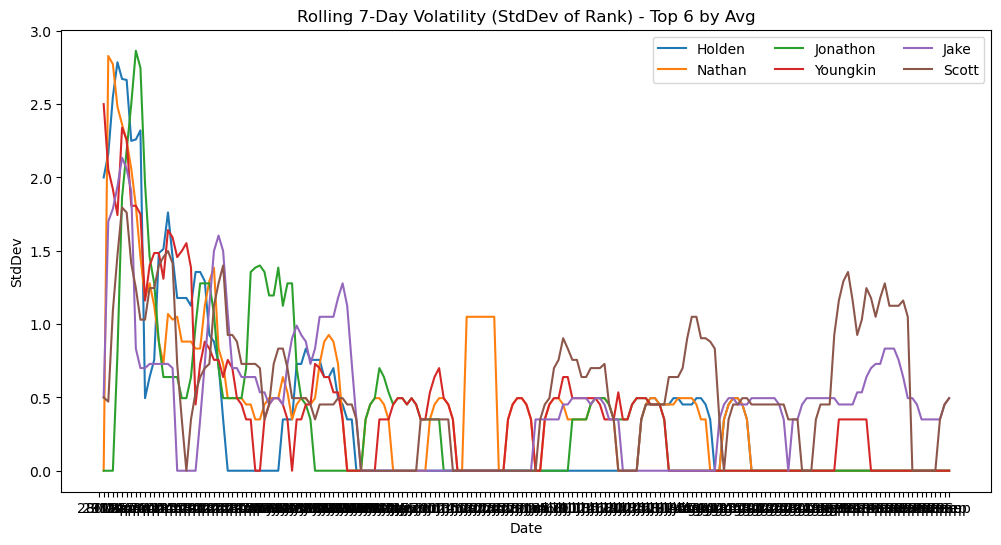

In [12]:

# Rolling 7-day volatility for top 6 by average
people_order=list(stand_avg['Name'])
fig, ax = plt.subplots(figsize=(12,6))
for name in people_order[:6]:
    ax.plot(df['Date'], df[name].rolling(7, min_periods=2).std(ddof=0), label=name)
ax.set_title('Rolling 7-Day Volatility (StdDev of Rank) - Top 6 by Avg')
ax.set_xlabel('Date'); ax.set_ylabel('StdDev'); ax.legend(ncol=3)
plt.show()


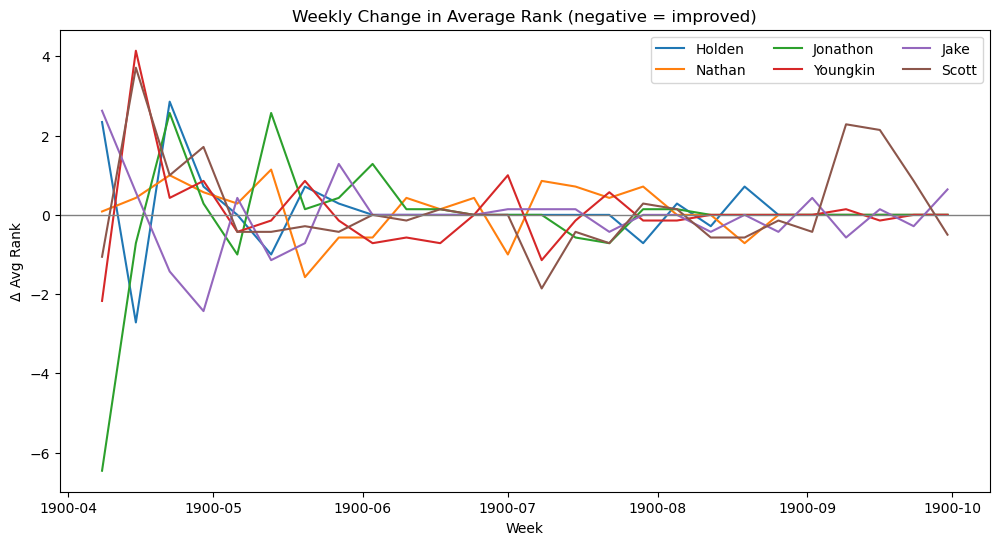

In [13]:

# Weekly deltas for top 6 by average (week-over-week change)
weekly_d = weekly.diff()
fig, ax = plt.subplots(figsize=(12,6))
for name in people_order[:6]:
    ax.plot(weekly_d.index, weekly_d[name], label=name)
ax.axhline(0, color='gray', lw=1)
ax.set_title('Weekly Change in Average Rank (negative = improved)')
ax.set_xlabel('Week'); ax.set_ylabel('Δ Avg Rank'); ax.legend(ncol=3)
plt.show()
